# Presentación y objetivo

El objeto del presente proyecto es el de desarrollar una Red Neuronal Recurrente (RNN) que sea capaz de clasificar con éxito tweets relacionados con el COVID-19. Para este fin, se va a llevar a cabo un análisis de sentimiento de los textos extraídos directamente de Twitter aplicando técnicas de Procesamiento de Lenguaje Natural (NLP).

![Imagen](https://i.ibb.co/ZdYTJhn/NLP-header4.png)

El conjunto de datos incluye tweets ya etiquetados, por lo que se van a aplicar métodos de aprendizaje supervisados. En esencia, se trata de un problema de clasificación multiclase.

# Carga de librerías necesarias

In [1]:
# Cargando librerías para EDA y modelado
import numpy as np
import pandas as pd
import os
import re
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

# Para codificaciones one-hot
from tensorflow.keras.utils import to_categorical

# Para tratamiento y limpieza de texto
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Evaluación
from sklearn.metrics import classification_report, accuracy_score

# Cargando los datos

Se va a trabajar con dos archivos de partida:
- "Corona_NLP_train.csv", que serán aquellos datos que utilizaremos para entrenar el modelo.
- "Corona_NLP_test.csv", que será el dataset a partir del cual validaremos las clasificaciones obtenidas.

En primer lugar, definimos la cabecera:

In [2]:
col_names = [
    'User',
    'Name',
    'Location',
    'Date',
    'Tweet Content',
    'Sentiment'
]

In [3]:
df_train = pd.read_csv('Corona_NLP_train.csv', header = 0, names = col_names, encoding = 'latin1')

In [4]:
df_train.head()

,User,Name,Location,Date,Tweet Content,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


El dataset contiene únicamente 6 parámetros, donde **UserName** y **ScreenName** se han representado como códigos numéricos a fin de preservar la privacidad de los usuarios.

Procedemos de forma análoga con los datos de test:

In [5]:
df_test = pd.read_csv('Corona_NLP_test.csv', header=0, names = col_names, encoding='latin1')

In [6]:
df_test.head()

,User,Name,Location,Date,Tweet Content,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


# Análisis Exploratorio (EDA)

Uno de los pasos preliminares más importantes a la hora de realizar cualquier modelo consiste en llevar a cabo la exploración de los datos con objeto de obtener y comprender toda la información que éstos contienen. Además, esta etapa permite determinar si se presentan datos vacíos o faltantes y si éstos son relevantes para la Red Neuronal.

In [7]:
df_train.shape

(41157, 6)

El dataframe de entrenamiento cuenta con 41.157 filas y 6 columnas.

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User           41157 non-null  int64 
 1   Name           41157 non-null  int64 
 2   Location       32567 non-null  object
 3   Date           41157 non-null  object
 4   Tweet Content  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Donde 8590 tweets no cuentan con la Ubicación (Location) establecida.

In [9]:
df_test.shape

(3798, 6)

El dataframe de test cuenta con 3.798 filas y 6 columnas.

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User           3798 non-null   int64 
 1   Name           3798 non-null   int64 
 2   Location       2964 non-null   object
 3   Date           3798 non-null   object
 4   Tweet Content  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


Nuevamente, se presentan 834 tweets sin localización.

Para el proyecto, los parámetros relevantes van a ser el contenido de los tweets (texto) así como el sentimiento vinculado a los mismos, por lo que no es necesario complementar la información faltante o suprimir las filas con estos parámetros nulos.

Los posibles estados emocionales asociados a los tweets, que se corresponden con las etiquetas del modelo supervisado, son:

In [11]:
for sentiment in df_train['Sentiment'].unique():
    print(sentiment)

Neutral
Positive
Extremely Negative
Negative
Extremely Positive


In [12]:
num_classes = len(df_train['Sentiment'].unique())

In [13]:
print(f"El número total de sentimientos asociados a los textos es de {num_classes}")

El número total de sentimientos asociados a los textos es de 5


Para comprobar el número total de tweets ligados a cada estado emocional:

In [14]:
print(df_train.Sentiment.value_counts())

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64


Comprobamos esta distribución con el siguiente diagrama:

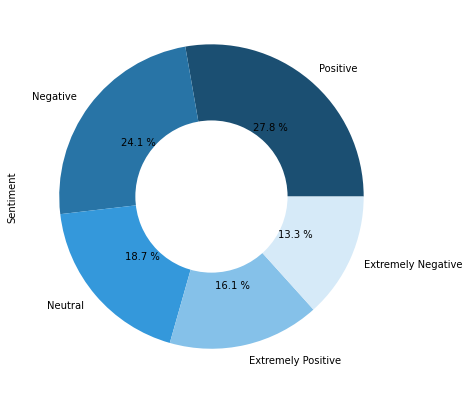

In [15]:
plt.figure(figsize=(7, 7))
colors = ['#1b4f72', '#2874a6', '#3498db', '#85c1e9', '#d6eaf8']
df_train['Sentiment'].value_counts().plot(kind='pie', colors = colors, autopct="%0.1f %%")
plt.pie([1,0,0,0], radius = 0.5, colors = 'w')

plt.show()

## Hashtags

En este apartado, comprobamos cuáles son los hashtags más frecuentes en los datos de entrenamiento:

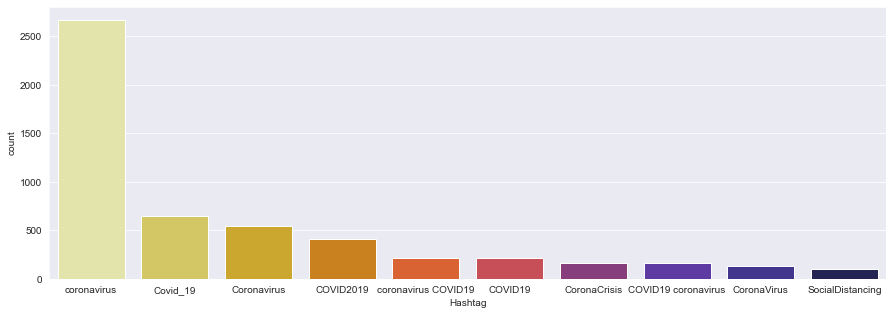

In [16]:
def find_hash(text):
    line = re.findall(r'(?<=#)\w+',text)
    return " ".join(line)

df_train['hash'] = df_train['Tweet Content'].apply(lambda x: find_hash(x))
temp = df_train['hash'].value_counts()[:][1:11]
temp = temp.to_frame().reset_index().rename(columns = {'index':'Hashtag','hash':'count'})

plt.figure(figsize =(15, 5))
sns.set_style("darkgrid")
sns.barplot(x = "Hashtag", y = "count", data = temp, palette = 'CMRmap_r')
plt.show()

## Menciones

Las menciones más frecuentes se muestran en la siguiente gráfica:

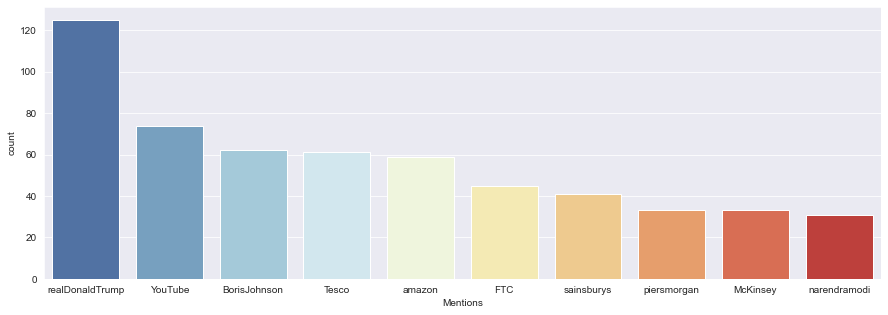

In [17]:
def mentions(text):
    line = re.findall(r'(?<=@)\w+',text)
    return " ".join(line)

df_train['mentions'] = df_train['Tweet Content'].apply(lambda x: mentions(x))
temp = df_train['mentions'].value_counts()[:][1:11]
temp = temp.to_frame().reset_index().rename(columns = {'index':'Mentions','mentions':'count'})

plt.figure(figsize =(15, 5))
sns.barplot(x = "Mentions",y = "count", data = temp, palette = 'RdYlBu_r')
plt.show()

# Limpieza de los datos (preprocesamiento)

Se realiza una primera limpieza de los datos:

In [19]:
def clean(text):
    
    # eliminando urls
    text = re.sub(r'http\S+', '', text)

    # eliminando menciones
    text = re.sub(r'@\w+','',text)

    # eliminando hastags
    text = re.sub(r'#\w+', '', text)

    # eliminando caracteres extraños
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\r', '', text)


    # eliminando etiquetas
    text = re.sub('r<.*?>','', text)
    
    return text

In [20]:
df_train['Tweet Content'] = df_train['Tweet Content'].apply(lambda x: clean(x))

Para posteriormente realizar la descomposición de los datos de df_train en entrenamiento y validación:

In [21]:
X_train, X_val, y_train, y_val = train_test_split(df_train['Tweet Content'], df_train['Sentiment'], shuffle=True, test_size=0.2)

In [22]:
X_train = np.array(X_train)
X_train

array(['?19 protection online in USA regular prices  to                  ',
       ' How about delivering a box of fresh veg and supplies to every dr and nurse on the frontline of COVID-19 in Australia?     ',
       'COVID-19 has the potential to create more permanent behavior changes in the way people shop, consume media and how they regard the brands they do business with.   ',
       ...,
       "The U.S. energy sector is doing what it can to keep the bottom line in shape, but it's not going to be easy if prices don't cooperate.  Survival of U.S. Oil, Gas Sectors Said at Risk from Coronavirus, Withering WTI Prices ",
       'The  ruined sneezing in public the same way pedophiles ruined waving at toddlers in the grocery store.',
       'Anyone   has shit for brains. '], dtype=object)

Seguidamente definimos el tamaño del vocabulario a partir del cual se compondrán los tokens en vectores así como la forma en que se preprocesarán los textos (todo en minúsculas y sin signos de puntuación, eliminando espacios en blanco):

In [23]:
# Tamaño del vocabulario (un índice por token)
vocab_size = 10000

encoder = TextVectorization(
    max_tokens = vocab_size, 
    standardize = "lower_and_strip_punctuation",
    split = "whitespace", 
    ngrams=None, 
    output_mode = "int",
    output_sequence_length=None, 
    pad_to_max_tokens=False, 
    vocabulary=None
)

Aplicamos el método *adapt* para ajustar el estado de la capa de preprocesamiento al conjunto de datos. Esto hará que el modelo cree un índice de cadenas a números enteros.

***Nota: únicamente se han de emplear los datos de entrenamiento al llamar al método adapt (usar el conjunto de prueba podría filtrar información).***

In [24]:
encoder.adapt(X_train)

El método .adapt establece el vocabulario. Después del relleno y los tokens desconocidos, se ordenan por frecuencia resultando el siguiente vocabulario:

In [25]:
vocab = (encoder.get_vocabulary())

Para el cual mostramos las primeras 200 palabras:

In [26]:
print(vocab[:200])

['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'for', 'is', 'are', 'on', 'you', 'i', 'this', 'at', 'prices', 'covid19', 'store', 'food', 'with', 'supermarket', 'that', 'as', 'have', 'we', 'grocery', 'be', 'it', 'people', 'from', 'amp', '19', 'all', 'your', 'will', 'not', 'consumer', 'my', 'our', 'has', 'they', 'up', 'out', 'or', 'by', 'can', 'more', 'but', 'if', 'how', 'shopping', 'online', 'their', 'during', 'so', 'now', 'no', 'covid', 'about', 'get', 'need', 'what', 'just', 'pandemic', 'who', 'us', 'workers', 'panic', 'like', 'do', 'was', 'an', 'time', 'go', 'when', 'home', 'demand', 'some', 'sanitizer', 'help', 'there', 'coronavirus', 'hand', 's', 'its', 'going', 'stock', 'one', 'due', 'me', 'been', 'new', 'buying', 'them', 'work', 'here', 'please', 'after', 'crisis', 'only', 'because', 'oil', 'toilet', 'other', 'than', 'should', 'local', 'these', 'paper', 'over', 'stay', 'via', 'many', 'buy', 'shelves', 'today', 'keep', 'still', 'see', 'make', 'stores', 'being', 'those', 'deliv

In [27]:
vocab = np.array(vocab)

In [28]:
count = 0
vocab = np.array(encoder.get_vocabulary())
vocab
for palabra in vocab:
    count += 1

In [29]:
print("El número total de palabras de que se compone el vocabulario es:",count)

El número total de palabras de que se compone el vocabulario es: 10000


Vamos a comprobar cómo quedaría el texto codificado para un tweet aleatorio:

In [30]:
sample_tweet = X_train[250]
sample_tweet

'Shout outs to the incredible  for working hard to shine a light on how  has impacted the hospo industry. Our industry was the first hit and job losses have been insurmountable:Coronavirus: Bar staff told to look for supermarket jobs '

In [31]:
# Vamos a ver cómo queda este ejemplo codificado
codified_sample = encoder(sample_tweet).numpy()
codified_sample

array([1442, 8180,    3,    2, 2776,    8,  148,  329,    3, 5645,    6,
        839,   11,   50,   40, 1007,    2,    1,  280,   39,  280,   71,
          2,  182,  367,    4,  342, 1651,   24,   91,    1, 2529,  140,
        389,    3,  246,    8,   21,  445], dtype=int64)

Como se puede apreciar, se ha descompuesto el tweet del ejemplo en un vector con los índices de los tokens en el vocabulario definido.

# Creando el modelo

Transformación one-hot de las variables categóricas:

In [32]:
l = {"Neutral" : 0, "Positive" : 1, "Extremely Positive" : 2, "Negative" : 3, "Extremely Negative" : 4}

In [33]:
y_train = y_train.map(l)
y_val = y_val.map(l)

In [34]:
y_train

24783    0
13241    1
6214     1
9225     0
6625     3
        ..
1677     4
8408     1
6218     1
11500    4
15419    3
Name: Sentiment, Length: 32925, dtype: int64

In [35]:
y_train = to_categorical(y_train, num_classes = 5)
y_val = to_categorical(y_val, num_classes = 5)
y_train

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

Diseñamos las capas de que se compone el modelo:

In [36]:
model = Sequential()

model.add(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()),
                     output_dim = 32,
                     # Usamos masking para añadir padding y de este
                     # modo poder procesar secuencias de distintos tamaños
                     mask_zero = True))

model.add(Bidirectional(LSTM(32))) 
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.6))
model.add(Dense(5, activation = 'softmax'))

Lo compilamos:

In [37]:
model.compile(loss = 'categorical_crossentropy',
               optimizer = "adam",
               metrics = ["accuracy"])

Definimos los callbacks:

In [38]:
call_back = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

Para finalmente instanciarlo y entrenarlo:

In [39]:
%%time
history = model.fit(X_train, y_train,
                      epochs = 15,
                      callbacks = [call_back],
                      validation_data = (X_val, y_val))

Epoch 1/15
1029/1029 [==============================] - 37s 30ms/step - loss: 1.2530 - accuracy: 0.4635 - val_loss: 0.9102 - val_accuracy: 0.6510
Epoch 2/15
1029/1029 [==============================] - 29s 28ms/step - loss: 0.8121 - accuracy: 0.7103 - val_loss: 0.7113 - val_accuracy: 0.7413
Epoch 3/15
1029/1029 [==============================] - 28s 27ms/step - loss: 0.6488 - accuracy: 0.7839 - val_loss: 0.7006 - val_accuracy: 0.7518
Epoch 4/15
1029/1029 [==============================] - 27s 26ms/step - loss: 0.5433 - accuracy: 0.8202 - val_loss: 0.6969 - val_accuracy: 0.7521
Epoch 5/15
1029/1029 [==============================] - 29s 28ms/step - loss: 0.4647 - accuracy: 0.8455 - val_loss: 0.7376 - val_accuracy: 0.7457
Epoch 6/15
1029/1029 [==============================] - 29s 28ms/step - loss: 0.4047 - accuracy: 0.8641 - val_loss: 0.8691 - val_accuracy: 0.7312
Epoch 7/15
1029/1029 [==============================] - 31s 30ms/step - loss: 0.3450 - accuracy: 0.8822 - val_loss: 0.9102 -

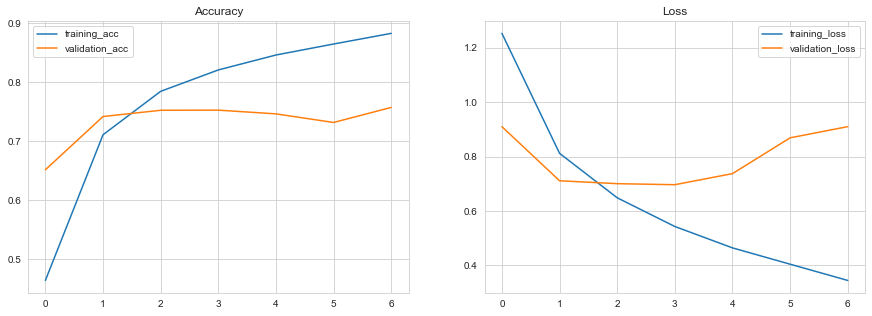

In [41]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(15, 5))

# Plot accuracy
ax = fig.add_subplot(121)
ax.plot(range(7), history.history['accuracy'])
ax.plot(range(7), history.history['val_accuracy'])
ax.legend(['training_acc', 'validation_acc'])
ax.set_title('Accuracy')

# Plot loss
ax2 = fig.add_subplot(122)
ax2.plot(range(7), history.history['loss'])
ax2.plot(range(7), history.history['val_loss'])
ax2.legend(['training_loss', 'validation_loss'])
ax2.set_title('Loss')

plt.show()

Se observa como se llega rápidamente al sobreajuste en el momento en que la pérdida de entrenamiento sigue reduciéndose pero en cambio la de validación aumenta. Este hecho se produce a partir de la segunda epoch y se mantiene tantas epochs como patience hayamos definido en el early-stopping.

In [42]:
train_lstm_results = model.evaluate(X_train, y_train, verbose=0, batch_size=64)
test_lstm_results = model.evaluate(X_val, y_val, verbose=0, batch_size=64)

In [43]:
print(f'Precisión datos entrenamiento: {train_lstm_results[1]*100:0.2f}')
print(f'Precisión datos validación: {test_lstm_results[1]*100:0.2f}')

Precisión datos entrenamiento: 88.71
Precisión datos validación: 75.21


Con esta evaluación comprobamos que con el modelo alcanzamos una precisión cercana al 89% para los datos de entrenamiento y ligeramente superior al 75% en los de validación.

# Realizando las predicciones

Preprocesamos los datos de test en primer lugar:

In [44]:
df_test['Tweet Content'] = df_test['Tweet Content'].apply(lambda x: clean(x))

In [45]:
X_test = df_test['Tweet Content']
y_test = df_test['Sentiment']

In [46]:
y_test = y_test.map(l)

In [47]:
y_test = to_categorical(y_test, num_classes = 5)
y_test

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

Siendo las predicciones:

In [48]:
pred = model.predict_classes(np.array(X_test))

In [49]:
pred

array([3, 1, 2, ..., 0, 4, 2], dtype=int64)

In [50]:
pred_cat = to_categorical(pred, num_classes = 5)
pred_cat

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

La precisión sobre los datos de test llega casi al 73%.

In [51]:
accuracy_score(y_test, pred_cat)

0.7285413375460769

In [52]:
print(classification_report(y_test, pred_cat))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       619
           1       0.67      0.75      0.71       947
           2       0.87      0.66      0.75       599
           3       0.67      0.71      0.69      1041
           4       0.74      0.72      0.73       592

   micro avg       0.73      0.73      0.73      3798
   macro avg       0.75      0.73      0.74      3798
weighted avg       0.74      0.73      0.73      3798
 samples avg       0.73      0.73      0.73      3798



Gracias al classification_report, comprobamos la precisión conseguida para cada una de las etiquetas. Se observa que los textos extremadamente positivos obtienen las mayores precisiones mientras que aquellos cuyo contenido es positivo o negativo son los que menos aciertos obtienen en su clasificación.